In [2]:
%matplotlib inline


import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

## Data Preprocessing

We'll be working with data coming from the [ The National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/). The background behind this data is an attempt to find out if instilling students with a growth mindset will improve their overall academic performance. In this dataset, the academic performance is recorded as a standardized `achievement_score`.

Besides the treated and outcome variables, the study also recorded some other features:

- schoolid: identifier of the student's school
- success_expect: self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment
- ethnicity: categorical variable for student race/ethnicity
- gender: categorical variable for student identified gender
- frst_in_family: categorical variable for student first-generation status, i.e. first in family to go to college
- school_urbanicity: school-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc
- school_mindset: school-level mean of students' fixed mindsets, reported prior to random assignment, standardize
- school_achievement: school achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students, standardized
- school_ethnic_minority: school racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American, standardized
- school_poverty: school poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line, standardized
- school_size: total number of students in all four grade levels in the school, standardized.

In [3]:
cat_cols = ['ethnicity', 'gender', 'school_urbanicity']
num_cols = ['school_mindset', 'school_achievement', 'school_ethnic_minority', 'school_poverty', 'school_size']
treatment_col = 'intervention'
label_col = 'achievement_score'

use_cols = [label_col, treatment_col] + num_cols + cat_cols
df = pd.read_csv('/content/learning_mindset.csv', usecols=use_cols)[use_cols]
print(df.shape)
df.head()

(10391, 10)


,achievement_score,intervention,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,ethnicity,gender,school_urbanicity
0,0.277359,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,2,4
1,-0.449646,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,12,2,4
2,0.769703,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,2,4
3,-0.121763,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,2,4
4,1.526147,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,1,4


Our data will be fed into a logistic regression in the next section, here we one hot encode the categorical variables. As the numeric features are already standardized, we leave them as is.

In [4]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.int32)
column_transformer = ColumnTransformer(
    transformers = [
        ('one_hot', one_hot_encoder, cat_cols)
    ],
    sparse_threshold=0,
    remainder='passthrough'
)
column_transformer.fit(df)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('one_hot',
                                 OneHotEncoder(dtype=<class 'numpy.int32'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['ethnicity', 'gender', 'school_urbanicity'])])

In [6]:
one_hot_encoder = column_transformer.named_transformers_['one_hot']
one_hot_encoded_cols = one_hot_encoder.get_feature_names_out(cat_cols).tolist()
columns = one_hot_encoded_cols + [label_col, treatment_col] + num_cols

df = pd.DataFrame(column_transformer.transform(df), columns=columns)
print(df.shape)
df

(10391, 29)


,ethnicity_1,ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,ethnicity_9,ethnicity_10,...,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4,achievement_score,intervention,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.277359,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.449646,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.769703,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.121763,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.526147,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.808867,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.156063,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.370820,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.396297,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702


## Outcome Analysis

It's often times useful to establish some baseline. Here, we would like to gauge what would the result look like if we don't use propensity score weighting to control for potential biases with assignment of individuals to the control and treatment group. 

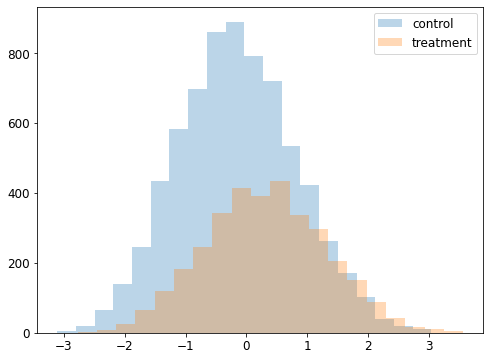

In [9]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# we can check the histogram of our label between the treatment and control
plt.hist(df.loc[df[treatment_col] == 0.0, label_col], bins=20, alpha=0.3, label='control')
plt.hist(df.loc[df[treatment_col] == 1.0, label_col], bins=20, alpha=0.3, label='treatment')
plt.legend()
plt.show()

In [10]:
# fitting a linear regression to estimate the outcome
linear = LinearRegression()
linear.fit(df[[treatment_col]], df[label_col])
print(linear.intercept_, linear.coef_)

-0.15380303423613792 [0.47227167]


In [11]:
smf.ols(f'{label_col} ~ {treatment_col}', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


We can use Linear Regression from different packages to establish our baseline estimates. The one from `statsmodels` will give us some additional statistical information. By blindly comparing individuals with and without the intervention, we can see that, on average, those in the treatment group achieved a achievement score 0.4723 higher than the control. Be aware that in this dataset is score was standardized, i.e. it means the treated is 0.4723 standard deviation higher than the untreated.

Upon establishing the baseline, our next task is to question these numbers.

## Propensity Score Estimation

We shall use a logistic regression to estimate our propensity score. Feel free to use other classification techniques, but keep in mind that other classification techniques might not produce well [calibrated probabilities](http://ethen8181.github.io/machine-learning/model_selection/prob_calibration/prob_calibration.html) and the utmost goal of propensity score estimation is to make sure to include all the confounding variables instead of getting taken away of the different kinds of classification model that we can potentially use. 

In [8]:
input_cols = one_hot_encoded_cols + num_cols

logistic = LogisticRegression()
logistic.fit(df[input_cols], df[treatment_col])

propensity_score = 'propensity_score'
df[propensity_score] = logistic.predict_proba(df[input_cols])[:, 1]
print(df.shape)
df.head()

(10391, 30)


,ethnicity_1,ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,ethnicity_9,ethnicity_10,...,school_urbanicity_3,school_urbanicity_4,achievement_score,intervention,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,propensity_score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.277359,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.313030
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.449646,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.294726
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.769703,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.313030
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.121763,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.313030
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.526147,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.338112


After training our propensity score, itis important to check for score overlap between the treated and untreated population. 

<ipython-input-12-71c26f759807>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(control_score, label='control')
<ipython-input-12-71c26f759807>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(treatment_score, label='treatment')


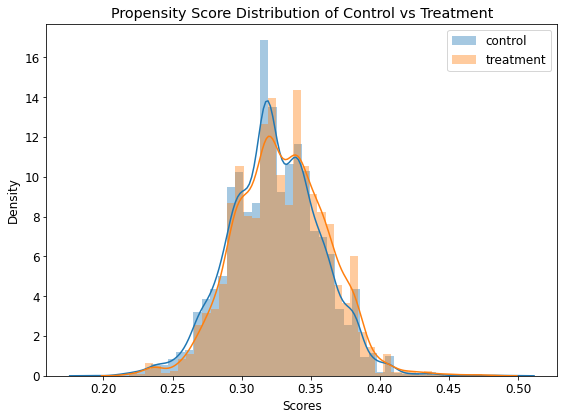

In [12]:
control_score = df.loc[df[treatment_col] == 0.0, propensity_score]
treatment_score = df.loc[df[treatment_col] == 1.0, propensity_score]

sns.distplot(control_score, label='control')
sns.distplot(treatment_score, label='treatment')
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

## Outcome Analysis with Inverse Propensity Score Weighting

The final step in our analysis is to run our outcome model using the propensity score as weights, i.e. fit a weighted regression. In order to use our propensity score as weights, we will need to apply some transformation known as **Inverse Propensity Weighting (IPW)**. For individuals in the treatment group, $w = \frac{1}{P(x)}$, whereas for individuals in the control group, $w = \frac{1}{1 - P(x)}$.


In [13]:
treatment_weight = 1.0 / treatment_score
control_weight = 1.0 / (1.0 - control_score)

print('Original Sample Size', df.shape[0])
print('Treated Population Sample Size', treatment_weight.sum())
print('Untreated Population Sample Size', control_weight.sum())

Original Sample Size 10391
Treated Population Sample Size 10390.321766315354
Untreated Population Sample Size 10390.613010741006


In [14]:
sample_weight = 'sample_weight'
df[sample_weight] = np.where(
    df[treatment_col] == 1.0,
    1.0 / df[propensity_score],
    1.0 / (1.0 - df[propensity_score])
)

Once the sample weight are created, we can re-estimate the outcome with a weighted Linear Regression.

In [15]:
smf.wls(f'{label_col} ~ {treatment_col}', data=df, weights=df[sample_weight]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1463,0.014,-10.771,0.000,-0.173,-0.120
intervention,0.4430,0.019,23.055,0.000,0.405,0.481


In [16]:
linear = LinearRegression()
linear.fit(df[[treatment_col]], df[label_col], sample_weight=df[sample_weight])
print(linear.intercept_, linear.coef_)

-0.14633238210068955 [0.44298379]


FYI, even though scikit-learn's LinearRegression by default doesn't give us an estimated standard error, we can estimate this using bootstrapping. i.e. by sampling with replacement from the original data, and computing the average treatment effect like before. After repeating this step for lots of times, we will get a distribution of the outcome estimation. We will also use this time to organize the overall workflow into one single code cell.

In [17]:
def run_propensity_score_estimation(df, input_cols, treatment_col, label_col):

    # df is our pre-processed data
    df = df.sample(frac=1, replace=True)

    # estimate the propensity score
    logistic = LogisticRegression()
    logistic.fit(df[input_cols], df[treatment_col])
    propensity_score = logistic.predict_proba(df[input_cols])[:, 1]

    # calculate the inverse propensity weight
    sample_weight = np.where(
        df[treatment_col] == 1.0,
        1.0 / propensity_score,
        1.0 / (1.0 - propensity_score)
    )

    # estimate the outcome using weighted regression
    linear = LinearRegression()
    linear.fit(df[[treatment_col]], df[label_col], sample_weight=sample_weight)
    return linear.coef_[0]

In [18]:
from joblib import Parallel, delayed

np.random.seed(88)

# the bootstrap approach of computing standard error can be computationally expensive on large datasets.
bootstrap_sample = 1000
parallel = Parallel(n_jobs=4)
ates = parallel(delayed(run_propensity_score_estimation)(df,
                                                         input_cols,
                                                         treatment_col,
                                                         label_col)
                for _ in range(bootstrap_sample))

ates = np.array(ates)
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.4427647389237973
95% C.I.: (0.40309461570847355, 0.4820129337897346)


# Reference

- [Github: Python Causality Handbook - Propensity Score](https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html)
- [Github: Python Causality Handbook - Beyond Confounders](https://matheusfacure.github.io/python-causality-handbook/07-Beyond-Confounders.html)
- [A Practical Guide for Using Propensity Score Weighting in R](http://www.math.umd.edu/~slud/s818M-MissingData/PropensityScoreWeightingR.pdf)